# The first prototype of the sensitivity analysis workflow. 

The workflow is designed to run from the inside of the docker container and assumes a specific folder layout.  

Authors: Tobey Carman and Elchin Jafarov

## Working with the docker 
Assuming that docker was successfully installed, navigate to your local dvmdostem folder:

1. Strat the containers <br/>
`$ docker compose up -d` <br/>
2. Enter to the container <br/>
`$ docker compose exec dvmdostem-run bash` <br/>
3. Start jupyter notebook inside the /work folder <br/>
`$ jupyter notebook --ip 0.0.0.0 --no-browser --allow-root` <br/>
4. Copy the url into your browser. <br/>
5. When done. Shut down container <br/>
`$ docker compose down` <br/>

In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import output_utils as ou
import param_util as pu
import os
import subprocess

import Sensitivity


In [29]:
param_specs = [
    {'name':'cmax', 'cmtnum':4, 'pftnum':3, 'bounds':[100,700],'enabled':True },
    {'name':'rhq10', 'cmtnum':4, 'pftnum':None, 'bounds':[0.1,5],'enabled':True },
    {'name':'micbnup', 'cmtnum':4, 'pftnum':None, 'bounds':[0.1,10],'enabled':True },
]

In [30]:
def generate_sample_matrix(pspecs, N, method='uniform'):
    
    if not method == 'uniform':
        raise RuntimeError("Not implemented yet!")
    
    sample_matrix = {}
    for i, p in enumerate(filter(lambda x: x['enabled'], param_specs)):
        samples = np.linspace(p['bounds'][0], p['bounds'][1], N)
        sample_matrix[p['name']] = samples

    return pd.DataFrame(sample_matrix)

In [63]:
sample_matrix = generate_sample_matrix(param_specs, 10)
sample_matrix.head()


,cmax,rhq10,micbnup
0,100.000000,0.100000,0.1
1,166.666667,0.644444,1.2
2,233.333333,1.188889,2.3
3,300.000000,1.733333,3.4
4,366.666667,2.277778,4.5


In [65]:
driver = Sensitivity.SensitivityDriver(param_specs, sample_matrix)

In [66]:
%time driver.setup_multi()

PROC:<ForkProcess name='ForkPoolWorker-68' parent=115 started daemon>  PROC:<ForkProcess name='ForkPoolWorker-67' parent=115 started daemon>   {'cmax': 166.66666666666669, 'rhq10': 0.6444444444444445, 'micbnup': 1.2000000000000002}PROC:<ForkProcess name='ForkPoolWorker-69' parent=115 started daemon>   PROC:<ForkProcess name='ForkPoolWorker-72' parent=115 started daemon>  
PROC:<ForkProcess name='ForkPoolWorker-73' parent=115 started daemon>     [SA:setup] /work/scripts/setup_working_directory.py --input-data-path /data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_CALM_Toolik_LTER_10x10/ /data/workflows/sensitivity_analysis/sample_000000001{'cmax': 500.0, 'rhq10': 3.366666666666667, 'micbnup': 6.7}PROC:<ForkProcess name='ForkPoolWorker-70' parent=115 started daemon>  

{'cmax': 433.33333333333337, 'rhq10': 2.8222222222222224, 'micbnup': 5.6}{'cmax': 233.33333333333334, 'rhq10': 1.188888888888889, 'micbnup': 2.3000000000000003}[SA:setup] /work/scripts/setup_working_directory.py --input-da

 Found tag:  Desc:  nfall(2) root cfall(0) root  

 nfall(0)Found tag:Found tag: Desc:  Desc:      Desc:  rootnfall(0) kra   leave
  Desc:  Desc:  stem
 Found tag:  Desc:  leave
Found tag:  leave Found tag:
kra
    coeff(0) in maintenance resp. Found tag: nfall(2)
  Found tag: Found tag: Desc: cfall(1)nfall(1)   Desc:   krb(0)  Desc:  nfall(1) Desc:     coeff(0) in maintenance resp.  root  
  stem
 Desc: Found tag: Desc:  stem
 Found tag: 
 Found tag:  coeff(1) in maintenance resp.(leave) stemkrb(0)kraFound tag: 

cfall(2)   Found tag:Found tag:nfall(2) Desc:    Desc:    nfall(2) Desc:   Desc: krb(1)     coeff(0) in maintenance resp.  coeff(1) in maintenance resp.(leave)  
 root Desc:  root Desc: Found tag: 
  

 root coeff(1) in maintenance resp.(stem)Found tag:
krb(0)Found tag:Found tag:
 Found tag:    nfall(0)Found tag:krakrb(1)kra Desc:       Desc: krb(2) Desc:   Desc:  coeff(1) in maintenance resp.(leave)  Desc:      Desc:  leave    coeff(0) in maintenance resp.
 coeff(1) in maint

Found tag:Found tag: initsoln   Desc: cfall(2)  
 Desc: Found tag:  initavln
 Found tag: Desc:   
nfall(0)  Desc:  
Found tag: nfall(1)  Desc:  
Found tag: nfall(2)  Desc:  
Found tag: kra  Desc:  
Found tag: krb(0)  Desc:  
Found tag: krb(1)  Desc:  
Found tag: krb(2)  Desc:  
Found tag: frg  Desc:  
Found tag: micbnup  Desc:  
Found tag: kdcrawc  Desc:  
Found tag: kdcsoma  Desc:  
Found tag: kdcsompr  Desc:  Using CMT4 as reference...

Found tag: kdcsomcrFound tag:   Desc: cmax  
 Desc:  
Found tag: nmaxPROC:<ForkProcess name='ForkPoolWorker-73' parent=115 started daemon>     Desc: {'cmax': 566.6666666666667, 'rhq10': 3.911111111111112, 'micbnup': 7.800000000000001} 

[SA:setup] /work/scripts/setup_working_directory.py --input-data-path /data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_CALM_Toolik_LTER_10x10/ /data/workflows/sensitivity_analysis/sample_000000007Found tag:
 cfall(0)  Desc:  
Found tag: cfall(1)  Desc:  
Found tag: cfall(2)  Desc:  
Found tag: nfall(0)  Desc: Using CM

Found tag: nfall(2)  Desc:   root
Found tag: kra  Desc:      coeff(0) in maintenance resp.
Found tag: krb(0)  Desc:   coeff(1) in maintenance resp.(leave)
Found tag: krb(1)  Desc:   coeff(1) in maintenance resp.(stem)
Found tag: krb(2)  Desc:   coeff(1) in maintenance resp.(root)
Found tag: frg  Desc:   fraction of available NPP (GPP after rm) for growth resp.
Found tag: micbnup  Desc:   parameter for soil microbial immobialization of N
Found tag: kdcrawc  Desc:   raw-material (litter) C decompositin rates at reference condition
Found tag: kdcsoma  Desc:  
Found tag: kdcsompr  Desc:  
Found tag: kdcsomcr  Desc:  
Using CMT0 as reference...
Found tag: rhq10  Desc:  
Found tag: moistmin  Desc:  
Found tag: moistopt  Desc:  
Found tag: moistmax  Desc:  
Found tag: lcclnc  Desc:  
Using CMT0 as reference...Found tag:
 fsoma  Desc: Found tag:  rhq10
 Found tag: Desc:  fsompr  
 Desc: Found tag:  moistmin
 Found tag: Desc:   
fsomcr Found tag: Desc:   
moistopt Found tag: Desc:   
som2co2Fou

In [67]:
%time driver.run_all_samples()

[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000001/config/config.js[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000000/config/config.js[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000002/config/config.js[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000006/config/config.js
[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000005/config/config.js



[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000003/config/config.js[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl

In [68]:
driver.collect_outputs()



In [70]:
import glob
file_list = glob.glob('/data/workflows/sensitivity_analysis/**/*sensitivity.csv', recursive=True)
df = pd.concat( map(pd.read_csv, file_list), ignore_index=True)
df = df.sort_values('p_cmax')
corr = df.corr()

print(corr)



             p_cmax   p_rhq10  p_micbnup     o_GPP    o_VEGC
p_cmax     1.000000  1.000000   1.000000  0.979094  0.962285
p_rhq10    1.000000  1.000000   1.000000  0.979098  0.962288
p_micbnup  1.000000  1.000000   1.000000  0.979094  0.962285
o_GPP      0.979094  0.979098   0.979094  1.000000  0.996561
o_VEGC     0.962285  0.962288   0.962285  0.996561  1.000000


<AxesSubplot:>

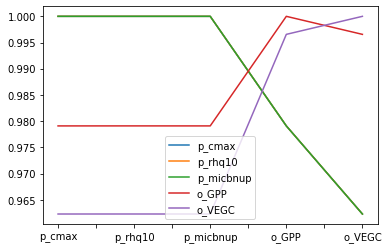

In [72]:
corr.plot()


In [16]:
# Sets initial values from the parameters directory - works better when used with 
# Sensitivity.setup_single() 
# Not sure how to use this yet...
for param in param_specs:
    pfile = pu.which_file(os.path.join(x2.work_dir, "parameters"), param['name'])
    data = pu.get_CMT_datablock(pfile, param['cmtnum'])
    data_dict = pu.cmtdatablock2dict(data)
    if param['pftnum'] is not None:
        pftkey = 'pft{}'.format(param['pftnum'])
        #print(param['name'], data_dict[pftkey][param['name']])
        param['initial_value'] = data_dict[pftkey][param['name']]
    else:
        #print(param['name'], data_dict[param['name']])
        param['initial_value'] = data_dict[param['name']]
    print(param)

